# Ice sheet flow

#### [Experiment B from Sachau et al. (2022)](https://gmd.copernicus.org/articles/15/8749/2022/)

#### UW2 example ported to UW3 

In [1]:
import underworld3 as uw

import numpy as np

import sympy

import os
import sys

if uw.mpi.size == 1:
    import matplotlib.pyplot as plt 

In [2]:
# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]

if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 5

i = km_index

maxX = L[i] * 1000.
min_bed_height = 500.           # we want a minimum of 500 m of rock beneath the ice
amplitude = 500.
average_bedthickness = 1000.
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height


resX = 80
resY = 32

print("resX: " + str(resX) + " resY: " + str(resY))


deform_mesh  = True
### number of loops over the deform mesh function to deform the mesh to the boundary
refinement_steps = 2
### perfect mesh deform not working
perfect_mesh = False

resX: 80 resY: 32


In [3]:
if deform_mesh:
    outputPath = f'./output/SachauEtAl2022-ExpB_deformedMesh_resx={resX}_resy={resY}/'
if perfect_mesh:
     outputPath = f'./output/SachauEtAl2022-ExpB_perfectMesh_resx={resX}_resy={resY}/'
else:
    outputPath = f'./output/SachauEtAl2022-ExpB_normalMesh_resx={resX}_resy={resY}/'

if uw.mpi.rank==0:      
    ### create folder if not run before
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [4]:
#import unit registry
u = uw.scaling.units
nd = uw.scaling.non_dimensionalise
dim = uw.scaling.dimensionalise

#set reference values
length    = maxX   # length of domain in metres 
height    = maxY   # height of domain in metres
density   = 910    # density of water in kg/m^3
viscosity = 1e14   # viscosity of ice in Pa.s
vel       = 100    # velocity in metres/yr

velocity = vel*u.meter/u.year
bodyforce = density * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

nd_length =  nd(length*u.meter)
nd_height =  nd(height*u.meter)
nd_gravity = nd(9.81 * u.meter / u.second**2)

#scaling values
lengthScale = length*u.meter
viscosityScale = viscosity*u.pascal*u.second

KLength = lengthScale.to_base_units()
KTime = (KLength/velocity).to_base_units() 
KViscosity = viscosityScale.to_base_units()
KM = (bodyforce * KLength**2 * KTime**2).to_base_units()
# KM = (KViscosity * KLength * KTime).to_base_units() ### may be a better mass scaling
scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"]      = KLength.to_base_units()
scaling_coefficients["[time]"]        = KTime.to_base_units()
scaling_coefficients["[mass]"]        = KM.to_base_units()
scaling_coefficients

[mass],5.55646203340956e+29 kilogram
[length],5000.0 meter
[temperature],1.0 kelvin
[time],1577880000.0 second
[substance],1.0 mole


In [5]:
maxX = nd(L[i] * 1000. * u.meter)
min_bed_height = nd(500.   * u.meter)        # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = nd(amplitude   * u.meter)
average_bedthickness = nd(average_bedthickness   * u.meter) 
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height

minY = minX = 0.

In [6]:
cell_height = maxY / resY
cell_width = maxX / resX

mesh = uw.meshing.StructuredQuadBox(
        elementRes=(resX, resY), minCoords=(minX, minY), maxCoords=(maxX, maxY))

x, y = mesh.X


In [7]:
vel = uw.discretisation.MeshVariable("U", mesh, mesh.dim, degree=2)
p = uw.discretisation.MeshVariable("P", mesh, 1, degree=1, )
p0 = uw.discretisation.MeshVariable("P0", mesh, 1, degree=1, )
eta = uw.discretisation.MeshVariable("\eta", mesh, 1, degree=1)
SR = uw.discretisation.MeshVariable("\dot{\epsilon}_{II}", mesh, 1, degree=1)
stress = uw.discretisation.MeshVariable("\tau", mesh, 1, degree=1)



In [8]:
def mesh_deform(section,fixPoint,mi):
    
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    # generally, mi ranges from 0.1 to 3, dependnig on the resolution 
 
    # note from Till: 
    # I normalize it, because then it becomes more clear to me.
    # normalization is not strictly necessary
    normalize = maxY - minY

    section /= normalize
    fixPoint /= normalize

    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  section[index] < fixPoint:
            zz_sqrt = (fixPoint - section[index])**mi
            zz_sqrt_max = (fixPoint - minCoord)**mi
            section[index] = fixPoint - (fixPoint - section[index]) * zz_sqrt / zz_sqrt_max

        if  section[index] > fixPoint:
            zz_sqrt = (section[index] - fixPoint)**mi
            zz_sqrt_max = (maxCoord - fixPoint)**mi
            section[index] = fixPoint + (section[index] - fixPoint) * zz_sqrt/zz_sqrt_max        
    
    return (section * normalize)

dx = (maxX - minX) / resX

if deform_mesh:

    ### keep looping over to refine the boundary
    for i in range(refinement_steps):
    
        with mesh.access():
            
            mesh_coords = mesh.data.copy()
    
            for index in range(resX+1):  
    
                start_x = dx * index
    
                interface_y =  surface_height - average_bedthickness + (amplitude * np.cos(2*np.pi*start_x*0.5))
                # interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )

    
                #print (start_x,interface_y)
                #lx.append(start_x)
                #ly.append(interface_y)
    
                #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
                ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
                
                # print(ind)
    
                mesh_coords[ind[0],1] = mesh_deform(mesh.data[ind[0],1], interface_y, 0.25)
                
            mesh.deform_mesh(mesh_coords)

In [9]:
# def mesh_deform_Ind(section,fixPoint_index,fixPoint,mi):
    
#     section[int(fixPoint_index)] = fixPoint
#     seqN = len(section)
    
#     # fixPoint_index (int): specify the index of the section to be at the place need to be refined
#     # fixPoint: the position to be refined
#     # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
#     for index in range(len(section)):
        
#         maxCoord = np.max(section)
#         minCoord = np.min(section)
        
#         if  index < fixPoint_index:
#             section[index] = minCoord + index*(fixPoint-minCoord)/fixPoint_index            
#             zz_sqrt = (fixPoint-section[index])**mi
#             zz_sqrt_max = (fixPoint-minCoord)**mi
#             section[index] = fixPoint-(fixPoint-section[index])*zz_sqrt/zz_sqrt_max

#         if  index > fixPoint_index:
#             section[index] = fixPoint + (index-fixPoint_index)*(maxCoord-fixPoint)/(seqN-fixPoint_index-1)
#             zz_sqrt = (section[index]-fixPoint)**mi
#             zz_sqrt_max = (maxCoord-fixPoint)**mi
#             section[index] =fixPoint+(section[index]-fixPoint)*zz_sqrt/zz_sqrt_max    
            
#     return (section)

# #picswarm = uw.swarm.VoronoiIntegrationSwarm(swarm)
# #picswarm.repopulate()

# # visualise the result

# if (perfect_mesh):
    
#     with mesh.access():
        
#         mesh_coords = mesh.data.copy()
        
#         for index in range(resX+1):  
#             start_x = dx * index
            
#             interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
            
#             ind = np.where(abs(mesh.data[:,0]-start_x)<0.01*dx)
            
#             mesh_coords[ind[0],1] = mesh_deform_Ind(mesh.data[ind[0],1],resY/2,interface_y,0.2)
            
#         mesh.deform_mesh(mesh_coords)

In [10]:
if uw.mpi.size == 1:
    import numpy as np
    import pyvista as pv
    import vtk

    pv.global_theme.background = "white"
    pv.global_theme.window_size = [1050, 500]
    pv.global_theme.antialiasing = True
    pv.global_theme.jupyter_backend = "client"
    pv.global_theme.smooth_shading = True
    pv.global_theme.camera["viewup"] = [0.0, 1.0, 0.0]
    pv.global_theme.camera["position"] = [0.0, 0.0, 1.0]

    mesh.vtk(outputPath+"tmp_ice_mesh.vtk")
    pvmesh = pv.read(outputPath + "tmp_ice_mesh.vtk")

    pl = pv.Plotter()

    pl.add_mesh(
        pvmesh,
        "Blue",
        "wireframe",
        opacity=0.5,
    )
    # pl.add_points(point_cloud, cmap="coolwarm", render_points_as_spheres=False, point_size=10, opacity=0.66)

    pl.show(cpos="xy")

Widget(value="<iframe src='http://localhost:61780/index.html?ui=P_0x147a09d50_0&reconnect=auto' style='width: …

### Set up stokes solver

In [11]:
stokes = uw.systems.Stokes(mesh, velocityField=vel, pressureField=p)
stokes.add_dirichlet_bc( [0.,0.], "Bottom")  # no slip on the base
stokes.add_dirichlet_bc( [sympy.oo, 0.], "Left")  # no vertical velocity on symmetry plane
stokes.add_dirichlet_bc( [sympy.oo, 0.], "Right")  # no vertical velocity on symmetry plane

stokes.add_essential_p_bc( [-5.0], "Left")  # no vertical velocity on symmetry plane

#### Set up the material distribution

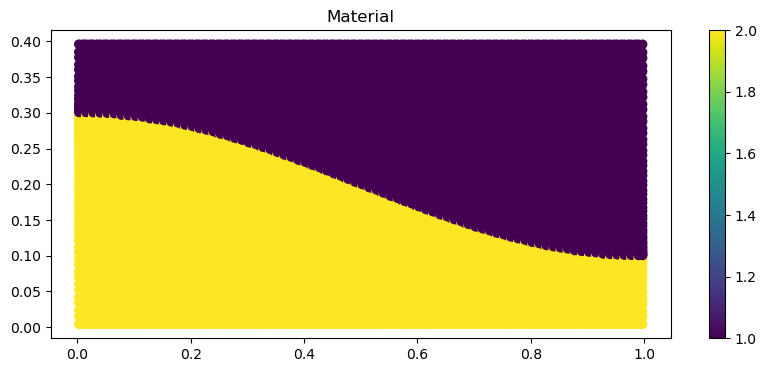

In [12]:
swarm = uw.swarm.Swarm(mesh=mesh)
material = uw.swarm.IndexSwarmVariable("M", swarm, indices=3)
swarm.populate()

# Initialise the 'materialVariable' data to represent different materials.
material_accommodation = 0  	# accommodation layer, a.k.a. Sticky Air
material_ice = 1  	# ice, isotropic
material_rock = 2   # rock

omega = 2.0 * sympy.pi / maxX
z_bed_function = surface_height - average_bedthickness + (amplitude * sympy.cos(omega * x*0.5) )
# z_bed_function = surface_height - average_bedthickness + amplitude * sympy.sin(omega * x) 

with swarm.access(material):
    material.data[:,0] = material_ice
    material.data[swarm.data[:,1] <= uw.function.evalf(z_bed_function, swarm.data)] = material_rock

    if uw.mpi.size == 1:
        ### material layout
        plt.figure(figsize=(10, 4))
        plt.title('Material')
        material_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=material.data)
        plt.colorbar(material_scatter)

In [13]:
stokes.constitutive_model = uw.constitutive_models.ViscousFlowModel
# stokes.constitutive_model.Parameters.shear_viscosity_0=1

surf_inclination = 0.5 * np.pi / 180 # 0.1 = Experiment D, 0.5 = Experiment B
z_hat =  sympy.Matrix([sympy.sin(surf_inclination), - sympy.cos(surf_inclination)])

air_density = nd(1*u.kilogram/u.meter**3)
ice_density = nd(910*u.kilogram/u.meter**3)  #in kg/m^3 (need to scale?)
rock_density = nd(2700*u.kilogram/u.meter**3)

density_fn = material.createMask([air_density, ice_density, rock_density])

# density_fn = sympy.Piecewise((rock_density, y <= z_bed_function ), 
#                              (ice_density, True) )

buoyancy = density_fn * nd_gravity * z_hat

stokes.bodyforce[0] = buoyancy[0]
stokes.bodyforce[1] = 0 * buoyancy[1]

In [16]:
mesh.petsc_save_checkpoint(0, meshVars=[eta, SR, stress, vel, p], outputPath=outputPath)

In [17]:
if uw.mpi.size == 1:
    stokes.petsc_options['pc_type'] = 'lu'
    # stokes.petsc_options['ksp_type'] = 'preonly'

### see the SNES output
stokes.petsc_options["snes_converged_reason"] = None
stokes.petsc_options["snes_monitor_short"] = None

In [18]:
### initial linear solve to get initial velocity field for the NL solve

sec_in_year = 3.1536e7
air_viscosity = nd((1e6/sec_in_year)*u.pascal*u.year)

rock_viscosity = nd((1e19/sec_in_year)*u.pascal*u.year)

ice_viscosity = nd((1e+12 / sec_in_year) *u.pascal*u.year)


viscosity_fn = material.createMask([air_viscosity, ice_viscosity, rock_viscosity])


stokes.constitutive_model.Parameters.shear_viscosity_0=1. #viscosity_fn

stokes.solve(zero_init_guess=True)

  0 SNES Function norm 0.304094 
  1 SNES Function norm 8.57512e-08 
Nonlinear  solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


3

In [19]:
# Visuals


import underworld3 as uw
import pyvista as pv
import underworld3.visualisation

pl = pv.Plotter(window_size=(1000, 500))

pvmesh = uw.visualisation.mesh_to_pv_mesh(mesh)
pvmesh.point_data["V"] = uw.visualisation.vector_fn_to_pv_points(pvmesh, vel.sym)
pvmesh.point_data["P"] = uw.visualisation.scalar_fn_to_pv_points(pvmesh, p.sym)
pvmesh.point_data["Vmag"] = uw.visualisation.scalar_fn_to_pv_points(pvmesh, vel.sym.dot(vel.sym))

velocity_points = underworld3.visualisation.meshVariable_to_pv_cloud(vel)
velocity_points.point_data["V"] = uw.visualisation.vector_fn_to_pv_points(velocity_points, vel.sym)

# point sources at cell centres for streamlines

points = np.zeros((mesh._centroids.shape[0], 3))
points[:, 0] = mesh._centroids[:, 0]
points[:, 1] = mesh._centroids[:, 1]
point_cloud = pv.PolyData(points)

pvstream = pvmesh.streamlines_from_source(
    point_cloud, vectors="V", integration_direction="forward", max_steps=1000
)

pl.add_mesh(
    pvmesh,
    cmap="coolwarm",
    edge_color="Black",
    show_edges=True,
    scalars="P",
    use_transparency=False,
    opacity=1.0,
)

pl.add_arrows(velocity_points.points, velocity_points.point_data["V"], mag=1, opacity=0.75)
# pl.add_mesh(pvstream)

pl.camera.SetPosition(0.75, 0.2, 1.5)
pl.camera.SetFocalPoint(0.75, 0.2, 0.0)
pl.camera.SetClippingRange(1.0, 8.0)

# pl.remove_scalar_bar("Omega")
# pl.remove_scalar_bar("mag")
# pl.remove_scalar_bar("V")

pl.show()




Widget(value="<iframe src='http://localhost:61780/index.html?ui=P_0x284a80810_1&reconnect=auto' style='width: …

In [20]:
with mesh.access():
    print(p.data.min(), p.data.max())    
    print(p0.data.min(), p0.data.max())

-5.0 1.513315930155076
0.0 0.0


ZeroDivisionError: division by zero

In [ ]:
if uw.mpi.size == 1:
    with swarm.access(material):
        n = 10 ### quiver nodes
        ### material layout
        plt.figure(figsize=(10, 4))
        plt.title('Material')
        material_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=material.data)
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(material_scatter)

In [ ]:
sec_in_year = 3.1536e7
air_viscosity = nd((1e6/sec_in_year)*u.pascal*u.year)

rock_viscosity = nd((1e19/sec_in_year)*u.pascal*u.year)

minViscIce = nd((1e+10 / sec_in_year) *u.pascal*u.year)
maxViscosityIce = nd((1e+15 / sec_in_year) *u.pascal*u.year)

# ice_viscosity = nd(float(1e13/sec_in_year)*u.pascal*u.year)   #in Pa.y

A = 1e-16
n = 3.

# ice_viscosity = nd((1e+12 / sec_in_year) *u.pascal*u.year)

viscosityFnIceBase = nd(0.5 * (A ** (-1./n)*(dim(stokes.Unknowns.Einv2, 1/u.second).m**((1.-n) / float(n))))*(u.pascal**n)*u.year)
ice_viscosity =  sympy.Max(sympy.Min(viscosityFnIceBase, maxViscosityIce), minViscIce) # nd((1e+12 / sec_in_year) *u.pascal*u.year) # 
viscosity_fn = material.createMask([air_viscosity, ice_viscosity, rock_viscosity])


stokes.constitutive_model.Parameters.shear_viscosity_0=viscosity_fn

In [ ]:
### sets the  tolerance
stokes.tolerance = 1e-6


# Non-linear solve
stokes.solve(zero_init_guess=False)

In [ ]:
# hw = 0.1 * mesh.get_min_radius()
# surface_fn = uw.maths.delta_function(y - maxY, hw)#  / uw.maths.delta_function(0.0, hw)
# base_fn = 2 * uw.maths.delta_function(y, hw)
# right_fn = 2 * uw.maths.delta_function(x - maxX, hw)
# left_fn = 2 * uw.maths.delta_function(x, hw)

In [ ]:
# if uw.mpi.size == 1:
#     plt.scatter(mesh.data[:,0], mesh.data[:,1], c=uw.function.evalf(surface_fn, mesh.data))

In [ ]:
# ### calibrate pressure using surface intergrals
# surfaceArea = uw.maths.Integral(mesh=mesh, fn=1.*surface_fn)

# surfacePressure = uw.maths.Integral(mesh=mesh, fn=p.sym[0]*surface_fn)

# area = surfaceArea.evaluate()
# p0 = surfacePressure.evaluate() 
# print(f'area: {area}, pressure: {p0}')

# with mesh.access(p):
#     p.data[:] -= p0 / area

# print (f'Calibration pressure {p0 / area}')

In [ ]:
### get the viscosity projection
nodal_visc_calc = uw.systems.Projection(mesh, eta)
nodal_visc_calc.uw_function = viscosity_fn
nodal_visc_calc.smoothing = 0.001
nodal_visc_calc.petsc_options.delValue("ksp_monitor")
nodal_visc_calc.solve(_force_setup=True)

### strain rate projection
SR_calc = uw.systems.Projection(mesh, SR)
SR_calc.uw_function = stokes.Unknowns.Einv2
SR_calc.smoothing = 0.001
SR_calc.petsc_options.delValue("ksp_monitor")
SR_calc.solve(_force_setup=True)

### stress projection
stress_calc = uw.systems.Projection(mesh, stress)
stress_calc.uw_function = stokes.stress_1d[2]  ### is this the shear stress?
# stress_calc.uw_function = 2*stokes.Unknowns.Einv2*viscosity_fn
stress_calc.smoothing = 0.001
stress_calc.petsc_options.delValue("ksp_monitor")
stress_calc.solve(_force_setup=True)

In [ ]:
mesh.petsc_save_checkpoint(1, meshVars=[eta, SR, stress, vel, p], outputPath=outputPath)

In [ ]:
if uw.mpi.size == 1:
    with swarm.access(material):
        n = 10 ### quiver nodes
        ### material layout
        plt.figure(figsize=(10, 4))
        plt.title('Material')
        material_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=material.data)
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(material_scatter)
        ### Density distribution
        plt.figure(figsize=(10, 4))
        plt.title('Density [kg/m$^{-3}$]')
        density_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=dim(uw.function.evalf(density_fn, swarm.data), u.kilogram/u.meter**3).m)
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(density_scatter)
        ### viscosity
        plt.figure(figsize=(10, 4))
        plt.title('log viscosity [Pa yr]')
        visc_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=np.log10(dim(uw.function.evalf(eta.sym[0], swarm.data), u.pascal*u.year).m))
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(visc_scatter)
        ### SR
        plt.figure(figsize=(10, 4))
        plt.title('log strain rate [s$^{-1}$]')
        visc_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=np.log10(dim(uw.function.evalf(SR.sym[0], swarm.data), 1/u.second).m))
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(visc_scatter)
        ### stress
        plt.figure(figsize=(10, 4))
        plt.title('stress [MPa]')
        visc_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=(dim(uw.function.evalf(stress.sym[0], swarm.data), u.pascal).m)/1e6)
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(visc_scatter)

        ### stress
        plt.figure(figsize=(10, 4))
        plt.title('Pressure [MPa]')
        visc_scatter = plt.scatter(swarm.data[:,0], swarm.data[:,1], c=(dim(uw.function.evalf(p.sym[0], swarm.data), u.pascal).m)/1e6)
        plt.quiver(mesh._centroids[:,0][::n], mesh._centroids[:,1][::n], uw.function.evalf(vel.sym[0], mesh._centroids)[::n], uw.function.evalf(vel.sym[1], mesh._centroids)[::n])
        plt.colorbar(visc_scatter)
    
    